# Analyzing Titanic survival rates

This is a pandas 101 tutorial.

## Import packages

I wanted to create a list of package dependencies similar to when I use python for app development so we can control what packages and versions are included in the environment.

Additionally, I created a virtual environment with `venv` to ensure all packages are isolated in its own env and not my local machine's root environment.

In [14]:

%%writefile ../requirements.txt

pandas==2.1.3
numpy==1.26.2
matplotlib==3.8.2
pytz
python-dateutil==2.8.2
seaborn==0.13.0
scikit-learn==1.3.2

Overwriting ../requirements.txt


In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('dataset/titanic3.csv')

## Cleaning steps

This step replaces the question marks in the `age` and `fare` columns with the numpy NaN value so that these column data types remain numeric.


In [3]:
data.replace('?', np.nan, inplace= True)
data = data.astype({"age": np.float64, "fare": np.float64})

## Analysis

<Axes: xlabel='survived', ylabel='fare'>

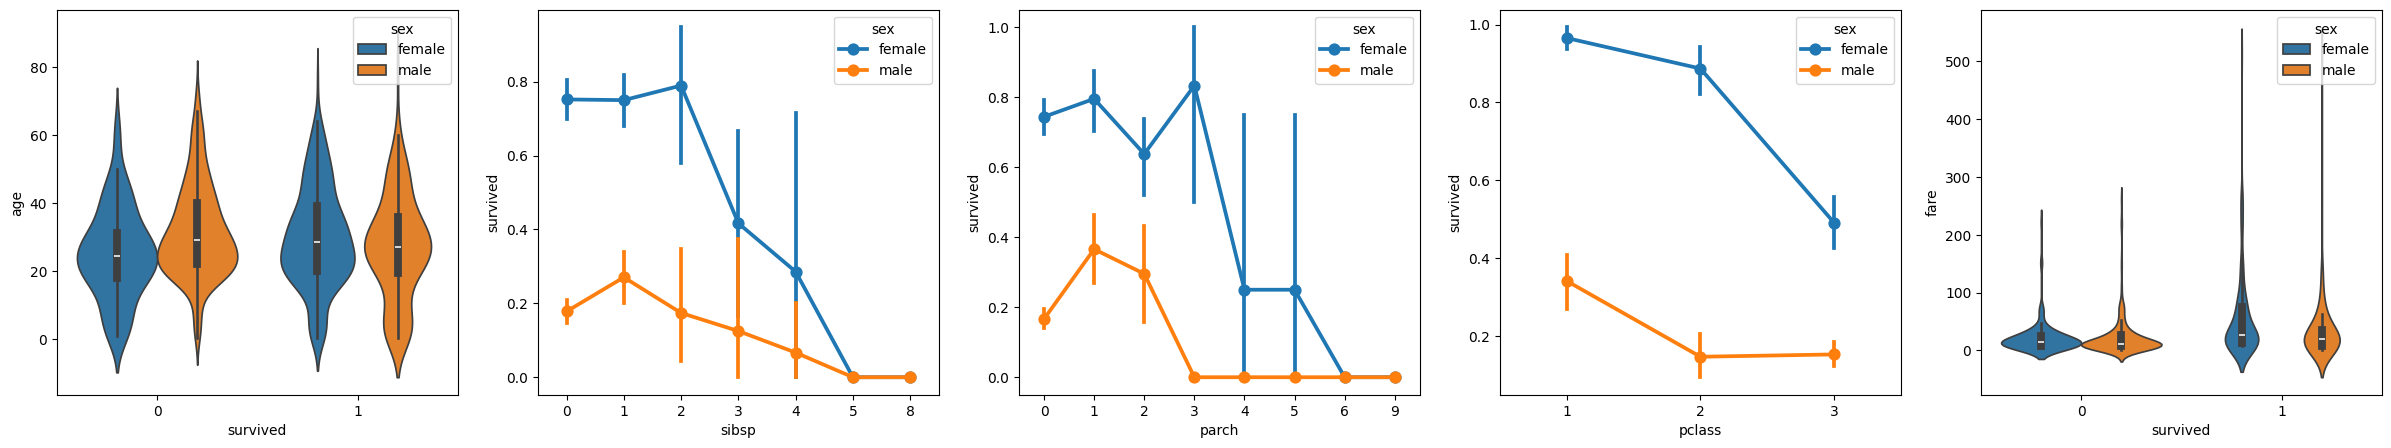

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

## Calculating correlations

- Examining survival rates with other variables

Additional variable transformations are required. To do so, all the variables used need to be numeric for the correlation calculation and currently gender is stored as a string. To convert those string values to integers, add and run the following code.

In [4]:
data.replace({'male': 1, 'female': 0}, inplace=True)

The closer a value is to 1, the higher the correlation between the value and the result. Use the following code to correlate the relationship between all variables and survival.

> Note: 
> sibsp = siblings or spouse
> parch = parents or children

In [5]:
data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN


## Creating new variables

We're going to assume that `sibsp` and `parch` are related in how they affect survivability, and group them into a new column called `relatives` to see whether the combination of them has a higher correlation to survivability.

Below we created a new variable called `relatives`. To do this, we will check if for a given passenger, the number of `sibsp` and `parch` is greater than 0 and, if so, you can then say that they had a relative on board.

Based on the `relatives`, we'll re-run our correlation analysis.


In [7]:
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)

data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN
relatives,0.201719


## Dropping variables

Since we learned that `sibsp` and `parch` have low correlation, we'll drop these variables from our model.

In [8]:
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()

## Training a model

Introducing the use of a new package called `scikit-learn`.

A common first step to training a model is to divide up the dataset into training and validation data. This allows you to use a portion of the data to train the model and a portion of the data to test the model. If you used all your data to train the model, you wouldn't have a way to estimate how well it would actually perform against data the model hasn't yet seen. A benefit of the scikit-learn library is that it provides a method specifically for splitting a dataset into training and test data.

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)

## Normalizing the data

By normalizing all the variables, you can ensure that the ranges of values are all the same.

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

The scikit-learn library also provides support for many of them and a chart to help select the one that's right for your scenario. For now, use the Naïve Bayes algorithm, a common algorithm for classification problems. 

In [12]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

With a trained model, you can now try it against the test data set that was held back from training. Add and run the following code to predict the outcome of the test data and calculate the accuracy of the model.

In [13]:
from sklearn import metrics
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885
